In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
def get_local_alt(f):
    to_local = lambda f : f.replace('/eos/user/e/ekoenig/','/store/user/ekoenig/')
    alt_pattern = to_local(f)

    # alt_glob = fc.fs.eos.glob(alt_pattern)
    # if any(alt_glob):
    #     return alt_glob
    
    remote_glob = fc.fs.cernbox.glob(f)
    if any(remote_glob):
        alt_glob = [ to_local(f) for f in remote_glob ]
        remote_glob = [ fc.fs.cernbox.fullpath(f) for f in remote_glob ]
        fc.fs.eos.batch_copy_to(remote_glob, alt_glob)

    alt_glob = fc.fs.eos.glob(alt_pattern)
    return alt_glob

In [3]:

treekwargs = dict(
    use_gen=False,
    treename='bbbbTree',
    normalization=None,
)

f_data = '/eos/user/e/ekoenig/bbbb_ntuples/debug_nanoHH4b/SKIM_private_jetht_filelist/ntuple.root'
run2_data = ObjIter([Tree( get_local_alt(f_data), **dict(treekwargs, normalization=None, color='black'))])

100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


In [4]:
run2_data.apply(len)

[4097849]

In [5]:

treekwargs = dict(
    use_gen=False,
    treename='Events',
    normalization=None,
)

f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/debug/{pairing}_2018_0L/data/jetht_tree.root'
f_data = f_pattern.format(pairing='mindiag')
data = ObjIter([Tree( get_local_alt(f_data), **dict(treekwargs, normalization=None, color='black'))])

[3.034GB/3.034GB][100%][==================================================][25.89MB/s]  
100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [6]:
np.divide(*(data + run2_data).apply(len).list)

0.9704357090756638

In [9]:
run2_data.HH_pt

[<Array [109, 45.1, 56.2, ... 53.9, 19.3, 116] type='4097849 * float32'>]

In [11]:
data.dHH_HH_pt

[<Array [39.5, 50.7, 181, ... 60.3, 59.7, 89.7] type='3976699 * float32'>]

100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


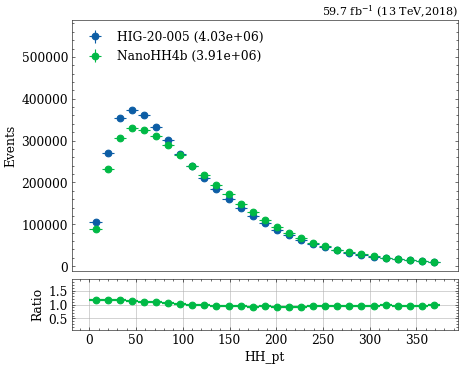

In [14]:
def HH_pt(tree):
    if 'HH_pt' in tree.fields:
        return tree.HH_pt
    else:
        return tree.dHH_HH_pt

study.quick(
    run2_data + data,
    h_color=None,
    h_label=['HIG-20-005','NanoHH4b'],
    varlist=[HH_pt],
    legend=True,
    ratio=True,
)

In [7]:
f_data = data[0].filelist[0]

In [18]:
th1_cutflow = ut.open(f'{f_data.fname}:h_cutflow')
cutflow = Histo.from_th1d(th1_cutflow)
cutflow_labels = th1_cutflow.axis().labels()

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

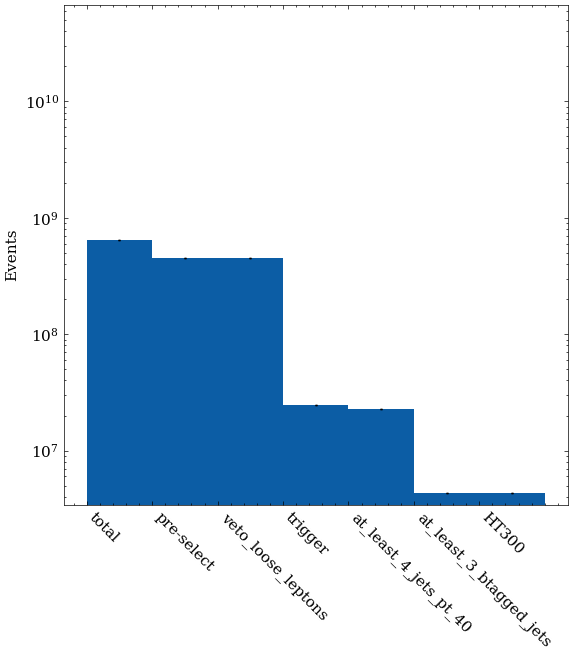

In [20]:
plot_histo(cutflow, log=True, xlabel=cutflow_labels)

In [24]:
import tabulate

cutflow_table = tabulate.tabulate(zip(cutflow_labels, cutflow.histo), tablefmt='raw', floatfmt='.0f')

print(cutflow_table)

-----------------------  ---------
total                    643652468
pre-select               450584352
veto_loose_leptons       448680508
trigger                   24464312
at_least_4_jets_pt_40     22775179
at_least_3_btagged_jets    4343894
HT300                      4338160
-----------------------  ---------


In [33]:
eff = cutflow.histo[1:] / cutflow.histo[:-1]

print( tabulate.tabulate(zip(cutflow_labels[1:], eff), tablefmt='raw', floatfmt='.3%') )

-----------------------  -------
pre-select               70.004%
veto_loose_leptons       99.577%
trigger                   5.453%
at_least_4_jets_pt_40    93.096%
at_least_3_btagged_jets  19.073%
HT300                    99.868%
-----------------------  -------
